# Benchmarks
---

The benchmarks serve as a sanity check that the more complex deep learning models have to outperform in order to demonstrate usefulness. We develop benchmarks of two categories, namely common-sense heuristics and simpler machine learning techniques by linear models and tree-based methods. Heuristics are naive methods that follow strict, hard-coded rules to make predictions; hence, they reflect how well the compressor can be modeled without actually building a model. The machine learning baselines are shallow methods that are much easier to implement than the deep neural networks, even though they require much of the same data preprocessing steps. Common for all of the baselines is that they are statistically simple, computationally lightweight methods, and their implementation requires little in terms of technical proficiency.

Summarized, we implement the following benchmarks: 

**Common-sense heuristics**
- Predict the previous value
- Predict the mean of the training data
- Predict the moving average of the sequence

**Simpler machine learning**
- **Linear models**
    - Ordinary Least Squares Linear Regression
    - Ridge regression
    - LASSO
    - Elastic Nets (ElNet)

- **Simpler Machine Learning**
    - Random Forest (RF)
    - Gradient Boosting Machines (GBM)

In [2]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

# import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib import rc 
from tabulate import tabulate
from decimal import Decimal

import functions as f

SEED = 100; np.random.seed(SEED)

In [3]:
c, p = f.color_palette()
sns.set(context='paper', style='whitegrid', palette=np.array(p))
plt.style.use('file://' + ROOT_PATH + "src/utils/plotparams.rc")

In [13]:
df_train, df_valid, df_test = f.load_data()
stats, target_tags, feature_tags, ts, ts_train, ts_valid, ts_test = f.load_metadata(return_ts=True)

# split datasets into features and targets
x_train, y_train = f.split_dataset(df_train.values, delay=1)
x_valid, y_valid = f.split_dataset(df_valid.values, delay=1)
x_test, y_test = f.split_dataset(df_test.values, delay=1)

# metadata
target_tags = df_train.columns.values[:3]
feature_tags = df_train.columns.values[3:]
target_stds = stats.loc[target_tags,"Std"].values
target_means = stats.loc[target_tags,"Mean"].values

#### Defining global functions for evaluation and plotting of the benchmarks

In [14]:
def evaluate_error(preds, targets, target_stdevs=target_stds):
    """
    Will evaluate the MAE of a set of predictions and targets.
    
    :param preds: Matrix of predictions with shape (n_obs, n_target_variables)
    :param targets: Matrix of true targets with shape (n_obs, n_target_variables)
    :param target_stdevs: 1D vector of the standard deviations of the target variables.
    
    :return return_dict: A dictionary with the computed error variables. 
    """
    
    maes = f.MAE(targets, preds, vector=True)
    maes_unstd = (maes * target_stdevs)
    avg_mae = np.mean(maes)
    avg_mae_unstd = np.mean(maes_unstd)

    err_df = pd.DataFrame(np.column_stack([["FT", "TT", "PT"], maes, maes_unstd]), 
                          columns=['Tag', 'MAE (Standardized)', 'MAE (Unstandardized)'])
    err_df.loc[len(err_df)] = ["Avg", avg_mae, avg_mae_unstd]
    str_table = tabulate(err_df, headers='keys', tablefmt='psql', floatfmt='.5f')

    return_dict = {
        'err_df': err_df,
        'err_table': str_table,
        'maes': maes,
        'maes_unstd': maes_unstd,
        'avg_mae': avg_mae,
        'avg_mae_unstd': avg_mae_unstd
    }
    
    return return_dict

def get_summary(val_dicts, test_dicts, columns, indexes, unstd=False, texpath=None, round_digits=4):
    """
    Method that concatenates validation and test dictionaries (as obtained by evaluate_error()) into a dataframe.
    Is typically used to get a summary of multiple methods and their performance on test and validation data. 
    
    :param val_dicts: Validation dictionaries as obtained by evalueate_error()
    :param test_dicts: Test dictionaries as obtained by evaluate_error()
    :param columns: Vector of column names for the dataframe
    :param indexes: Vector of index names for the dataframe
    :param unstd: Boolean if the MAEs should be unstandardized or not. Default=False. 
    :param texpath: Path to save the obtained latex output. Default=None. 
    :round_digit: The significant digits to round a decimal to, used in format_digit(). Default=4. 
    
    :return: The summary dataframe and the latex string of the dataframe. 
    """
    
    name = 'maes_unstd' if unstd else 'maes'
    val_data = []
    for i, d in enumerate(val_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        val_data.append(tmp)

    test_data = []
    for i, d in enumerate(test_dicts):
        tmp = np.append(d[name], d['avg_mae'])
        tmp = [format_digit(digit) for digit in tmp]
        test_data.append(tmp)

    val_df = pd.DataFrame(np.vstack(val_data), index = indexes, columns=columns)
    test_df = pd.DataFrame(np.vstack(test_data), index = indexes, columns=columns)
    summary_df = pd.concat([val_df, test_df], axis=1, keys=["Validation", "Test"])
    
    tex = f.latexify(summary_df)

    if texpath is not None: # save the file
        with open(texpath, 'w+') as file:
            file.write(tex)
    
    return summary_df, tex

## [1] Common-sense heuristics

We implement three heuristics: 
1. The first heuristic estimates the value at time t based on the observed preceding value.
2. The second heuristic is one that constantly predicts the variable’s mean in the training data.
3. The third and final heuristic predicts the moving average of the data seen so far.

First, we define some functions to evaluate and visualize the heuristics.

In [22]:
def evaluate_heuristic(func):
    """
    Evaluates a heuristic by printing results for the validation and testing data.
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :return val_errs, test_errs: The dictionaries obtained by the evaluate_error()-function. 
    """
    
    print("\nValidation data")
    preds, targets = func(y_valid)
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\nTesting data")
    preds, targets = func(y_test)
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

def visualise_heuristic(func, y_data=y_test, ts = ts_test, plot_from=28, n_obs=200, signal=2):
    """
    Visualises the heuristic with a sample plot. 
    
    :param func: A function representing the heuristic that returns predictions and targets.
    :param y_data: The data with the true targets. Default set to y_valid. 
    :param n_obs: The number of observations that will be plotted. Default set to 100. 
    :param signal: The target that will be plotted. Default set to 1, i.e. the temperature. 
    """
    
    preds, targets = func(y_data)
    
    preds = preds[:,signal] if np.array(preds).shape==targets.shape else np.repeat(preds[signal],len(y_data))
    targets = targets[:,signal]
    
    preds_unsc = preds * target_stds[signal] + target_means[signal]
    targets_unsc = targets * target_stds[signal] + target_means[signal]
    
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    interval = range(plot_from,plot_from+n_obs)
    ax.plot(ts[interval], preds_unsc[interval], lw=2, c=c["red"], label="Predicted")
    ax.plot(ts[interval], targets_unsc[interval], lw=2, c=c["blue_med"], label="Actual")
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=3, fancybox=False, shadow=False, frameon=False)
    
    ax.set_yticklabels([str(i.round(1)) for i in ax.get_yticks()])

    for label in ax.get_yticklabels()[::2]:
        label.set_visible(False)
    
    fig.show()

### Predict previous 
Predict the succeeding value to equal the preceeding, $y(t+1) = y(t)$.


 **** PREDICTING PREVIOUS ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.90735 |             3063.81951 |
|  1 | TT    |              0.22123 |                0.21607 |
|  2 | PT    |              0.55859 |                0.13824 |
|  3 | Avg   |              0.56239 |             1021.39127 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.78401 |             2647.34482 |
|  1 | TT    |              0.18297 |                0.17870 |
|  2 | PT    |              0.51566 |                0.12761 |
|  3 | Avg   |              0.49421 |              882.

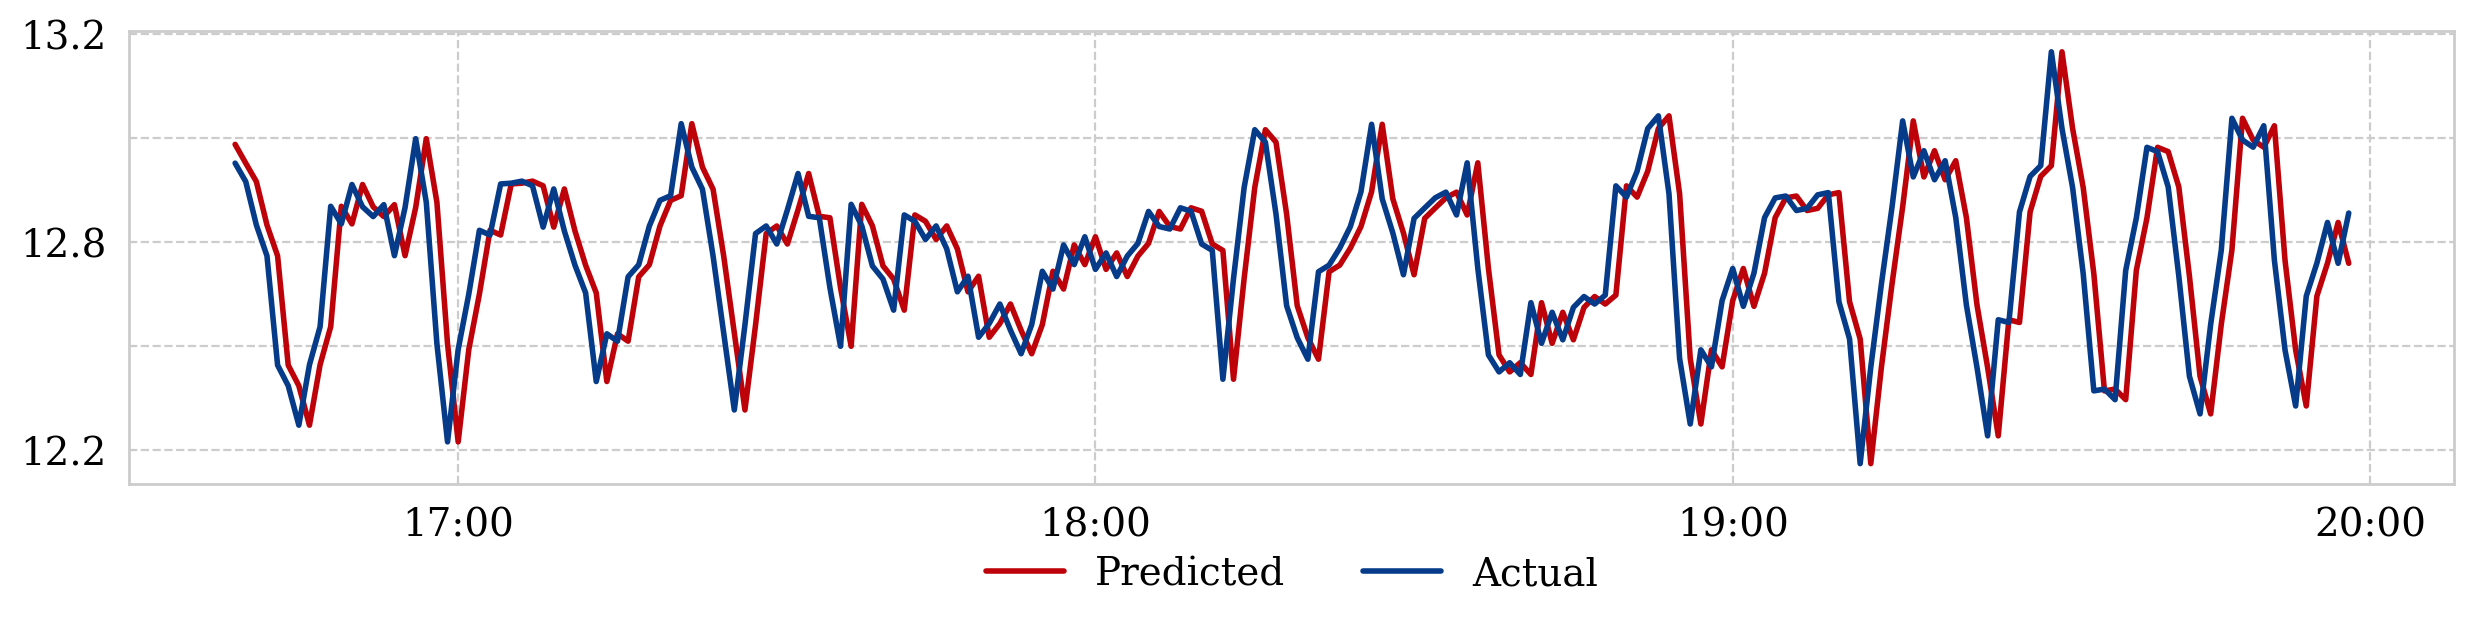

In [29]:
def predict_previous(y_data):
    preds = y_data[:-1,:].copy()
    targets = y_data[1:,:].copy()
    
    return preds, targets

print("\n **** PREDICTING PREVIOUS ****")
val_prev, test_prev = evaluate_heuristic(predict_previous)
visualise_heuristic(predict_previous)

### Predict mean
Always predict the mean of the training data, $y(t) = C = \sum_{i=0}^{T}y(i)$ where $T$ is the time of the last observation in the training data and $C$ is constant. 


 **** PREDICTING MEAN ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.85731 |             2894.84189 |
|  1 | TT    |              1.38530 |                1.35295 |
|  2 | PT    |              0.83288 |                0.20612 |
|  3 | Avg   |              1.02516 |              965.46699 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.81065 |             2737.30360 |
|  1 | TT    |              1.69267 |                1.65315 |
|  2 | PT    |              0.76120 |                0.18838 |
|  3 | Avg   |              1.08818 |              913.0483

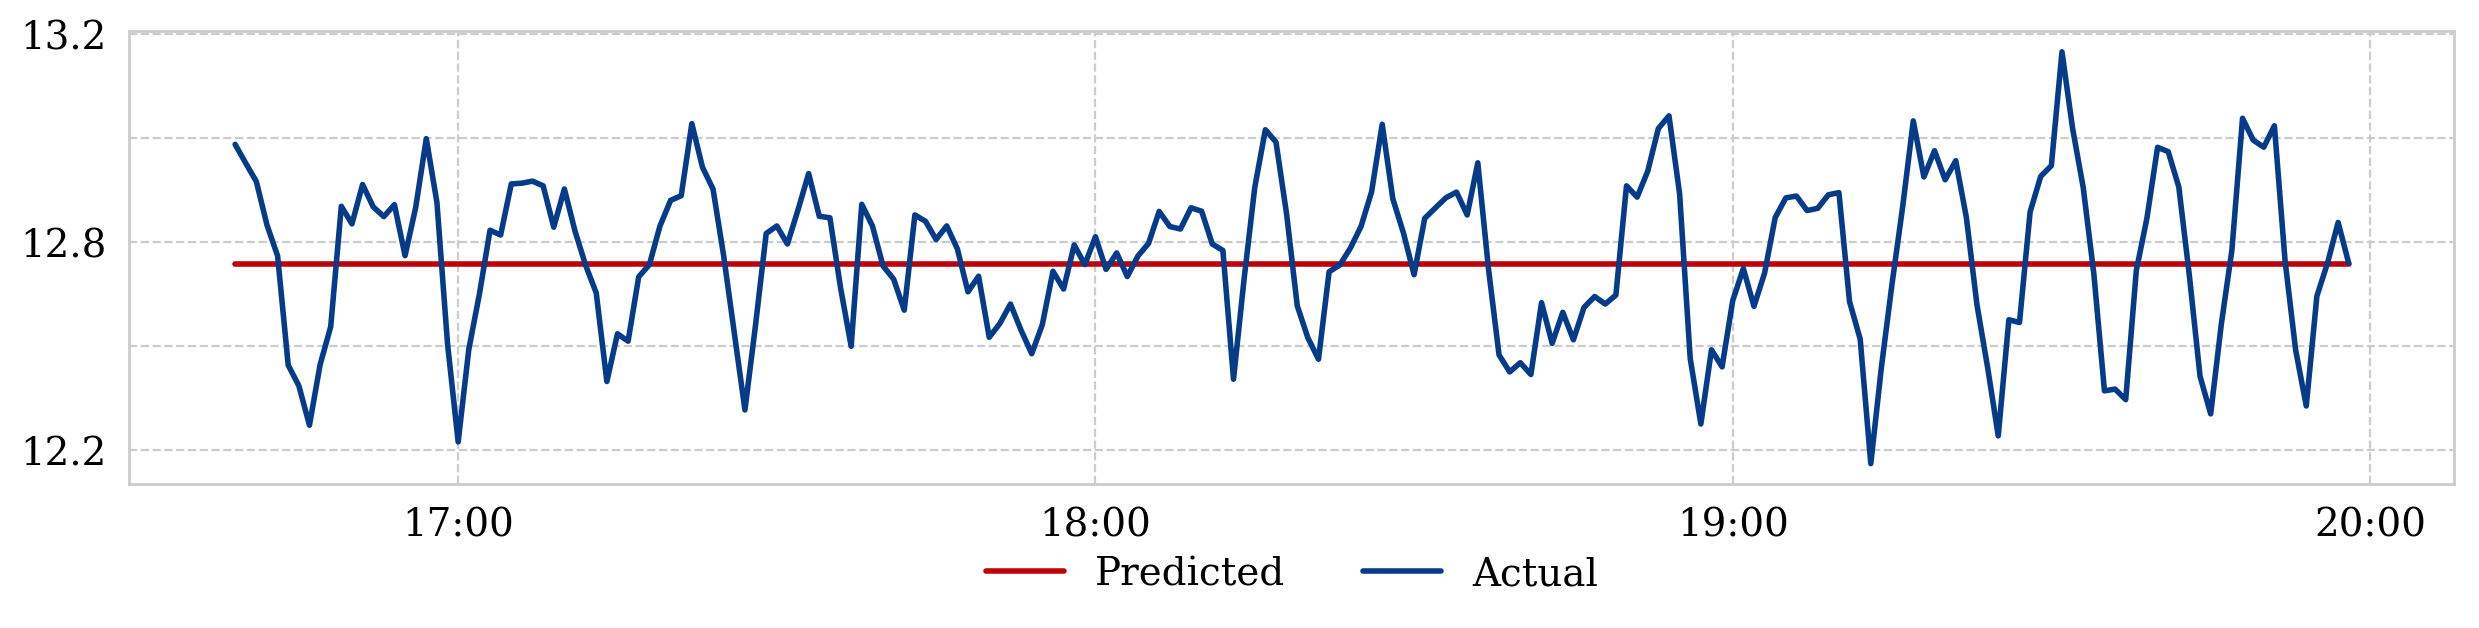

In [30]:
def predict_mean(y_data):
    preds = df_train[target_tags].mean().values
    targets = y_data
    return preds, targets

print("\n **** PREDICTING MEAN ****")
val_mean, test_mean = evaluate_heuristic(predict_mean)
visualise_heuristic(predict_mean)

### Predict simple moving average (SMA)
Predict the simple moving average, 
$ y_{t+1} = \frac{1}{n}\sum_{i=0}^{n}y_{t-i}$.


 **** PREDICTING SIMPLE MOVING AVERAGE ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.83423 |             2816.93836 |
|  1 | TT    |              0.71012 |                0.69354 |
|  2 | PT    |              0.83313 |                0.20618 |
|  3 | Avg   |              0.79249 |              939.27936 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.74390 |             2511.90851 |
|  1 | TT    |              0.71485 |                0.69815 |
|  2 | PT    |              0.76064 |                0.18824 |
|  3 | Avg   |              0.73980 |     

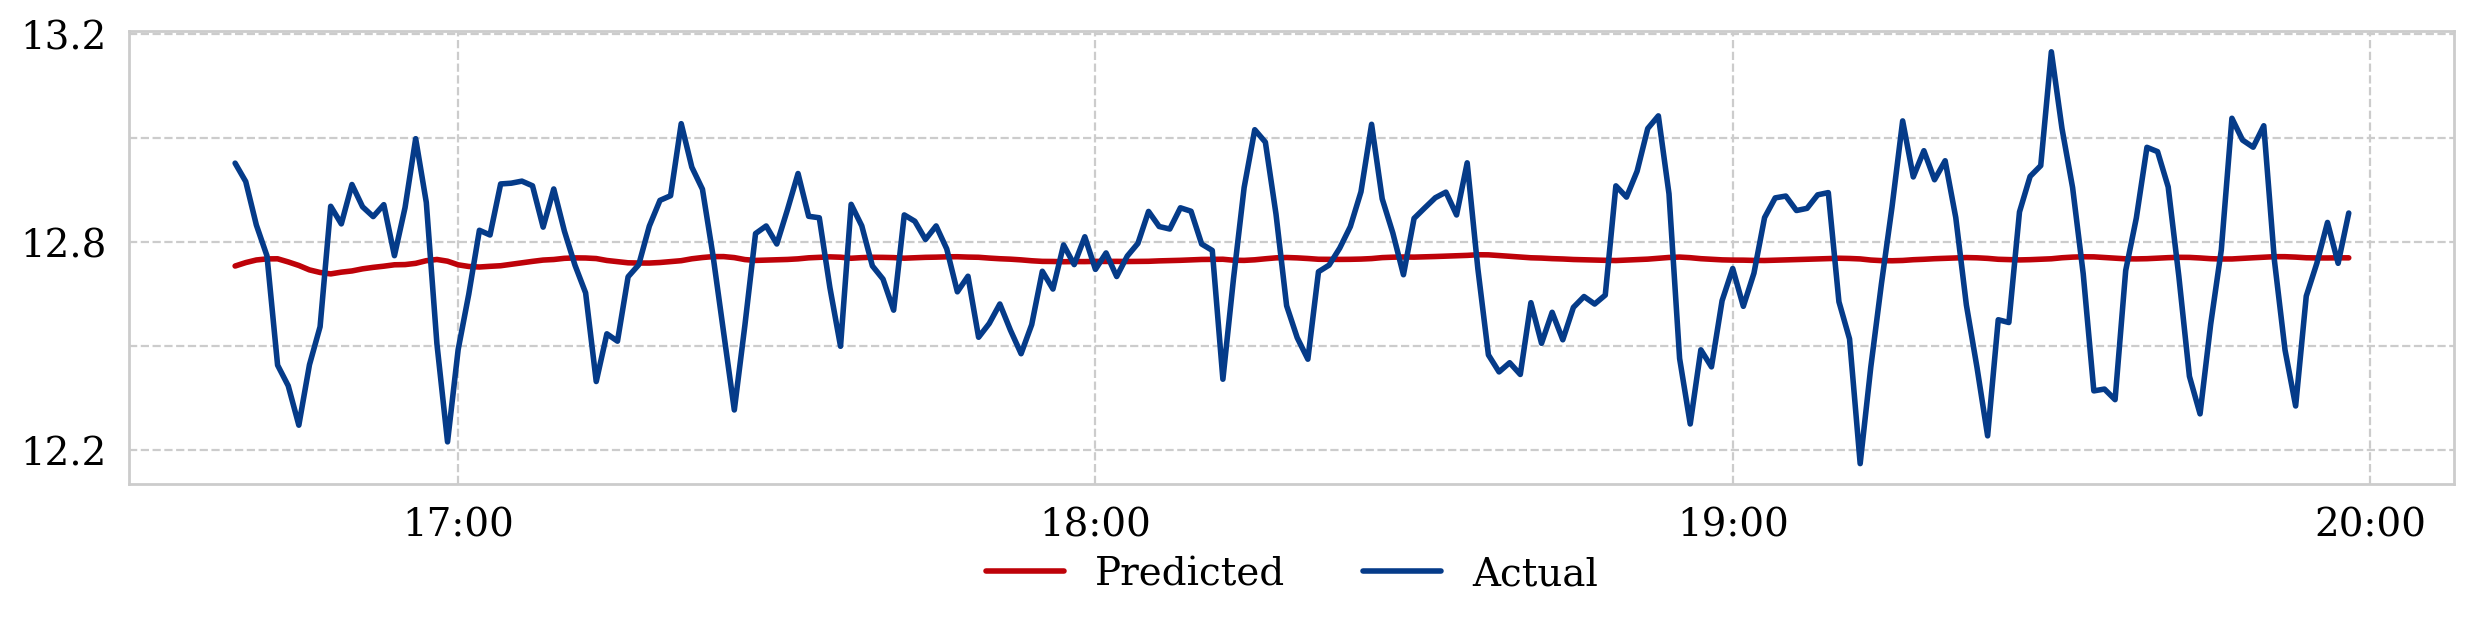

In [31]:
cumsum = np.cumsum(y_valid,axis=0)
ma = np.array([cumsum[n-1]/n for n in range(1,len(cumsum)+1)])

def predict_ma(y_data):
    cumsum = np.cumsum(y_data, axis=0)
    ma = np.array([cumsum[n-1]/n for n in range(1,len(cumsum)+1)])

    preds = ma[:-1]
    targets = y_data[1:]
    return preds, targets

print("\n **** PREDICTING SIMPLE MOVING AVERAGE ****")
val_ma, test_ma = evaluate_heuristic(predict_ma)
visualise_heuristic(predict_ma)

### Summary for the common-sense heuristics

In [32]:
indexes = ['Prev.', 'Mean', 'MA']
columns = ['FT', 'TT', 'PT', 'Avg']
texpath = ROOT_PATH + "latex-exports/benchmarks/" + "simple_heuristics_error_table.tex"
simple_heuristics_df, tex = get_summary(val_dicts = [val_prev, val_mean, val_ma], 
                                   test_dicts = [test_prev, test_mean, test_ma],
                                   columns=columns, indexes=indexes, unstd=False)
simple_heuristics_df.head()

Validation                            Test                        
              FT      TT      PT     Avg      FT      TT      PT     Avg
Prev.     0.9073  0.2212  0.5586  0.5624   0.784   0.183  0.5157  0.4942
Mean      0.8573  1.3853  0.8329  1.0252  0.8107  1.6927  0.7612  1.0882
MA        0.8342  0.7101  0.8331  0.7925  0.7439  0.7148  0.7606  0.7398

---

## [2] Linear Models

All the models are fit using the sklearn-package. Hold-out validation is used wherever relevant to find the optimal parameters of the fit.

#### Functions to evaluate and plot the models

In [40]:
def evaluate_linear_model(model, x_valid=x_valid, y_valid=y_valid, x_test=x_test, y_test=y_test):
    """
    Prints the performance of a model on the validation and testing data. Returns dictionaries of the validation
    and testing error. 
    
    :param model: The fitted model that can use the .predict() function
    :param x_valid: matrix of validation features. Default=x_valid.
    :param y_valid: matrix of validation targets. Default=y_valid.
    :param x_test: matrix of test features. Default=x_test.
    :param y_test: matrix of test targets. Default=y_test. 
    
    :return: dictionaries of validation and test errors as returned from evaluate_error()
    """
    
    print("\nValidation data")
    preds = model.predict(x_valid)
    targets = y_valid
    val_errs = evaluate_error(preds,targets)
    print(val_errs['err_table'])

    print("\nTesting data")
    preds = model.predict(x_test)
    targets = y_test
    test_errs = evaluate_error(preds,targets)
    print(test_errs['err_table'])
    
    return val_errs, test_errs

def plot_linear_model(model, x_data=x_valid, y_data=y_valid, time=ts_valid, 
                      start_idx=0, n_obs=200, signal=1):
    """
    Plots a sample of the linear model.
    """
    preds = model.predict(x_data) * target_stds + target_means
    targets = y_data * target_stds + target_means
    
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    interval = range(start_idx,start_idx+n_obs)
    ax.plot(time[interval], preds[interval,signal], lw=2, c=c["red"], label="Predicted")
    ax.plot(time[interval], targets[interval,signal], lw=2, c=c["blue_med"], label="Actual")
    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=3, fancybox=False, shadow=False, frameon=False)
    
    # format axes
    ax.set_yticklabels([str(i.round(1)) for i in ax.get_yticks()])
    [label.set_visible(False) for label in ax.get_yticklabels()[::2]]
    fig.show()

### Least Squares Linear Regression
Linear regression with least squares minimisation. No parameters to optimize. 


 **** LINEAR REGRESSION MODEL ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.69870 |             2359.28972 |
|  1 | TT    |              0.29017 |                0.28339 |
|  2 | PT    |              0.51010 |                0.12624 |
|  3 | Avg   |              0.49966 |              786.56645 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.61578 |             2079.27306 |
|  1 | TT    |              0.25265 |                0.24675 |
|  2 | PT    |              0.49072 |                0.12144 |
|  3 | Avg   |              0.45305 |              

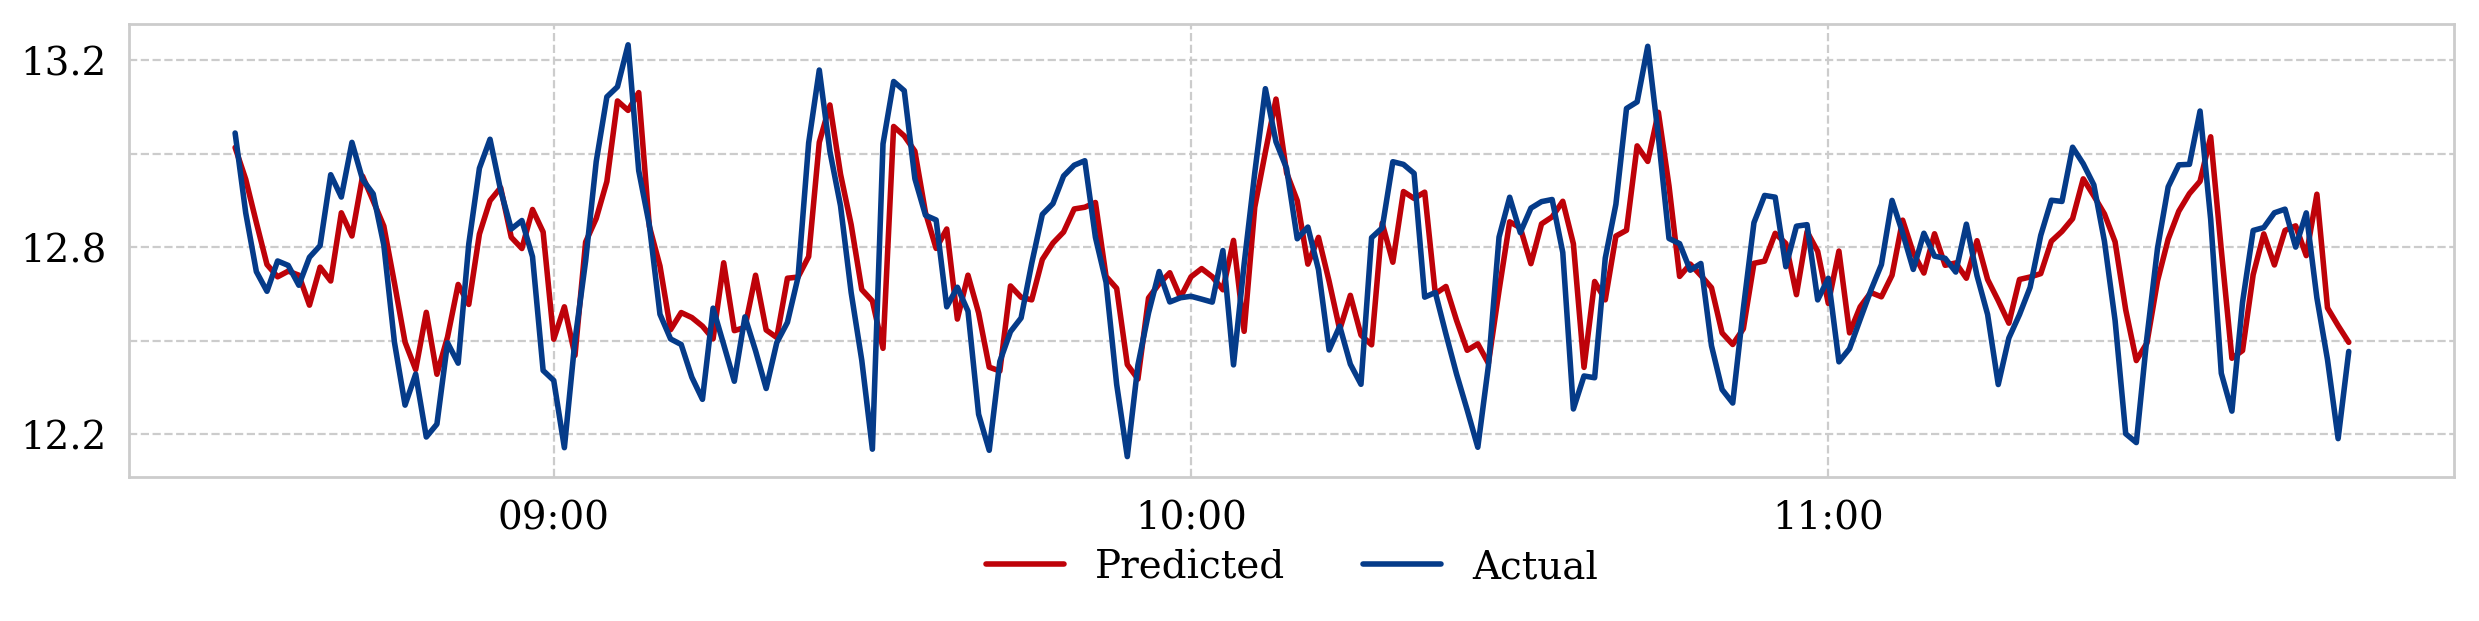

In [42]:
from sklearn.linear_model import LinearRegression
# using the standard settings from scikit-learn

lm = LinearRegression()
lm.fit(x_train, y_train)

print("\n **** LINEAR REGRESSION MODEL ****")
val_linear, test_linear = evaluate_linear_model(lm, x_valid, y_valid, x_test, y_test)
plot_linear_model(lm,signal=2)

### Ridge regression
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the L2-norm. Parameters to optimise with these models is the value of alpha ($\alpha$). This is found using hold-out-validation.

Best alpha by validation is: 0.01

 **** RIDGE REGRESSION MODEL ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.69870 |             2359.28968 |
|  1 | TT    |              0.29017 |                0.28339 |
|  2 | PT    |              0.51010 |                0.12624 |
|  3 | Avg   |              0.49966 |              786.56644 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.61578 |             2079.27289 |
|  1 | TT    |              0.25265 |                0.24675 |
|  2 | PT    |              0.49072 |                0.12144 |
|  3 | Avg   |    

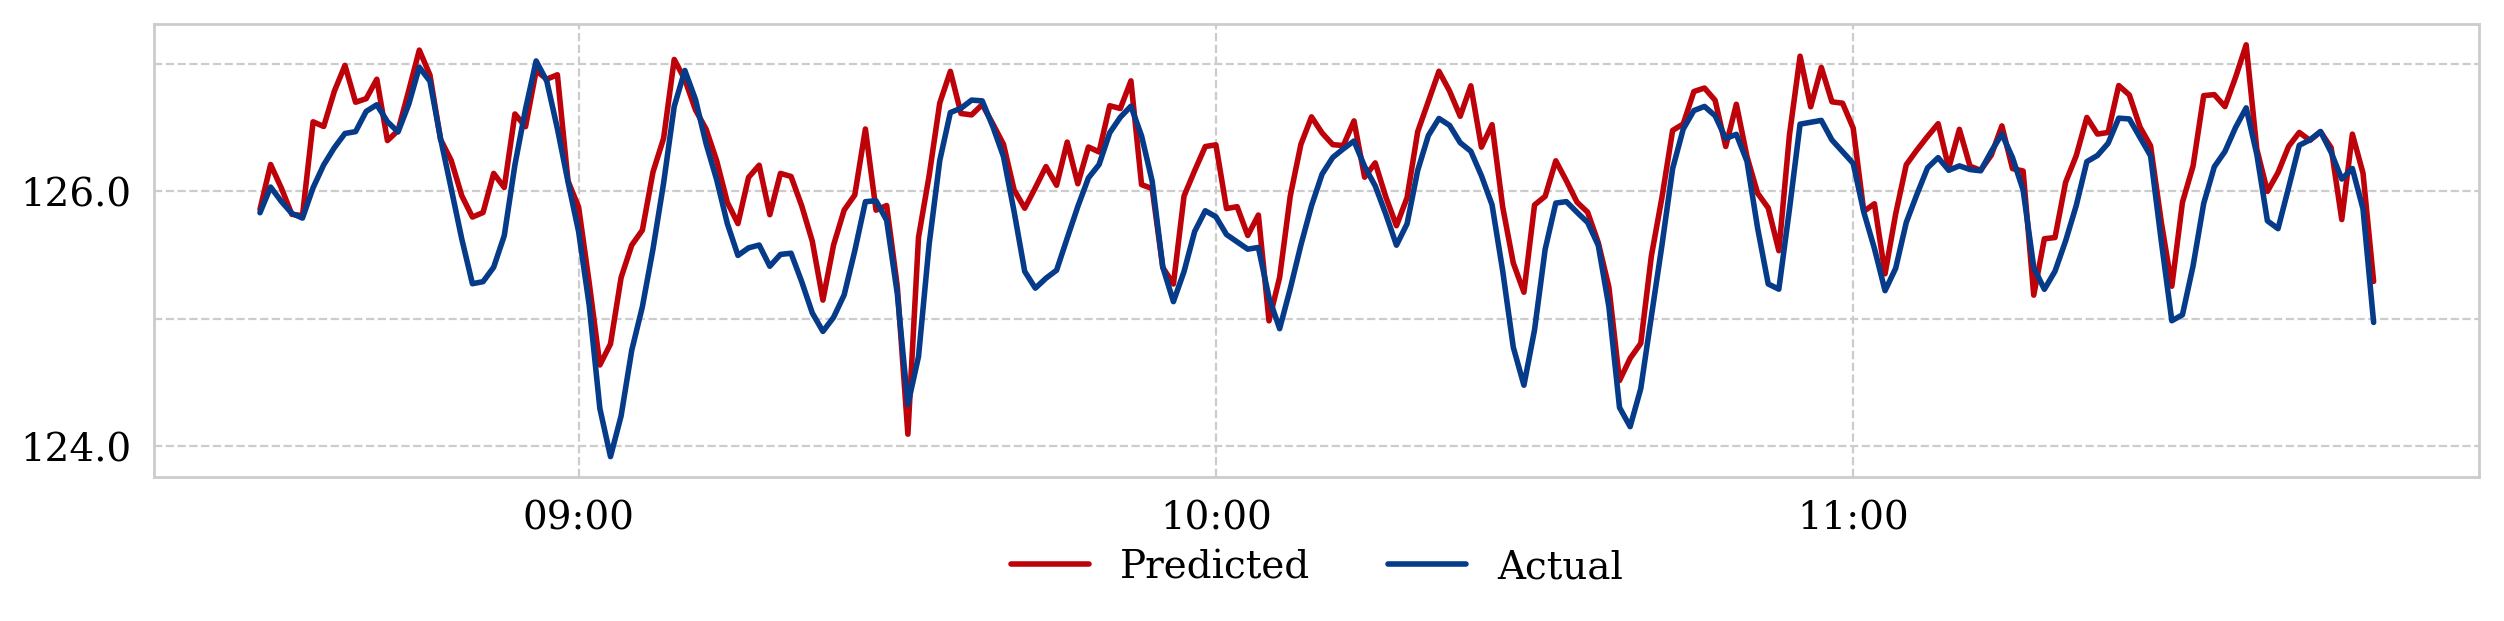

In [45]:
from sklearn.linear_model import Ridge

alphas = np.arange(0.01,1,0.01)
best_alpha = None
best_err = None
for a in alphas: 
    model = Ridge(alpha = a)
    model.fit(x_train,y_train)
    
    preds = model.predict(x_valid)
    targets = y_valid
    val_err = evaluate_error(preds,targets)['avg_mae']
    if best_err is None or val_err < best_err:
        best_alpha = a
        best_err = val_err

print("Best alpha by validation is:", best_alpha)
    
ridge = Ridge(alpha=best_alpha)
ridge.fit(x_train, y_train)

print("\n **** RIDGE REGRESSION MODEL ****")
val_ridge, test_ridge = evaluate_linear_model(ridge, x_valid, y_valid, x_test, y_test)
plot_linear_model(ridge)

### LASSO regression
A linear model trained with L1-norm as regularizer. Technically the Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty). Parameter to optimise with these models is the alpha value ($\alpha$). This is found using hold-out validation.

Best alpha by validation is: 0.01

 **** LASSO REGRESSION MODEL ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.69744 |             2355.03262 |
|  1 | TT    |              0.30102 |                0.29399 |
|  2 | PT    |              0.51159 |                0.12661 |
|  3 | Avg   |              0.50335 |              785.15107 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.61123 |             2063.91067 |
|  1 | TT    |              0.27104 |                0.26471 |
|  2 | PT    |              0.49115 |                0.12155 |
|  3 | Avg   |    

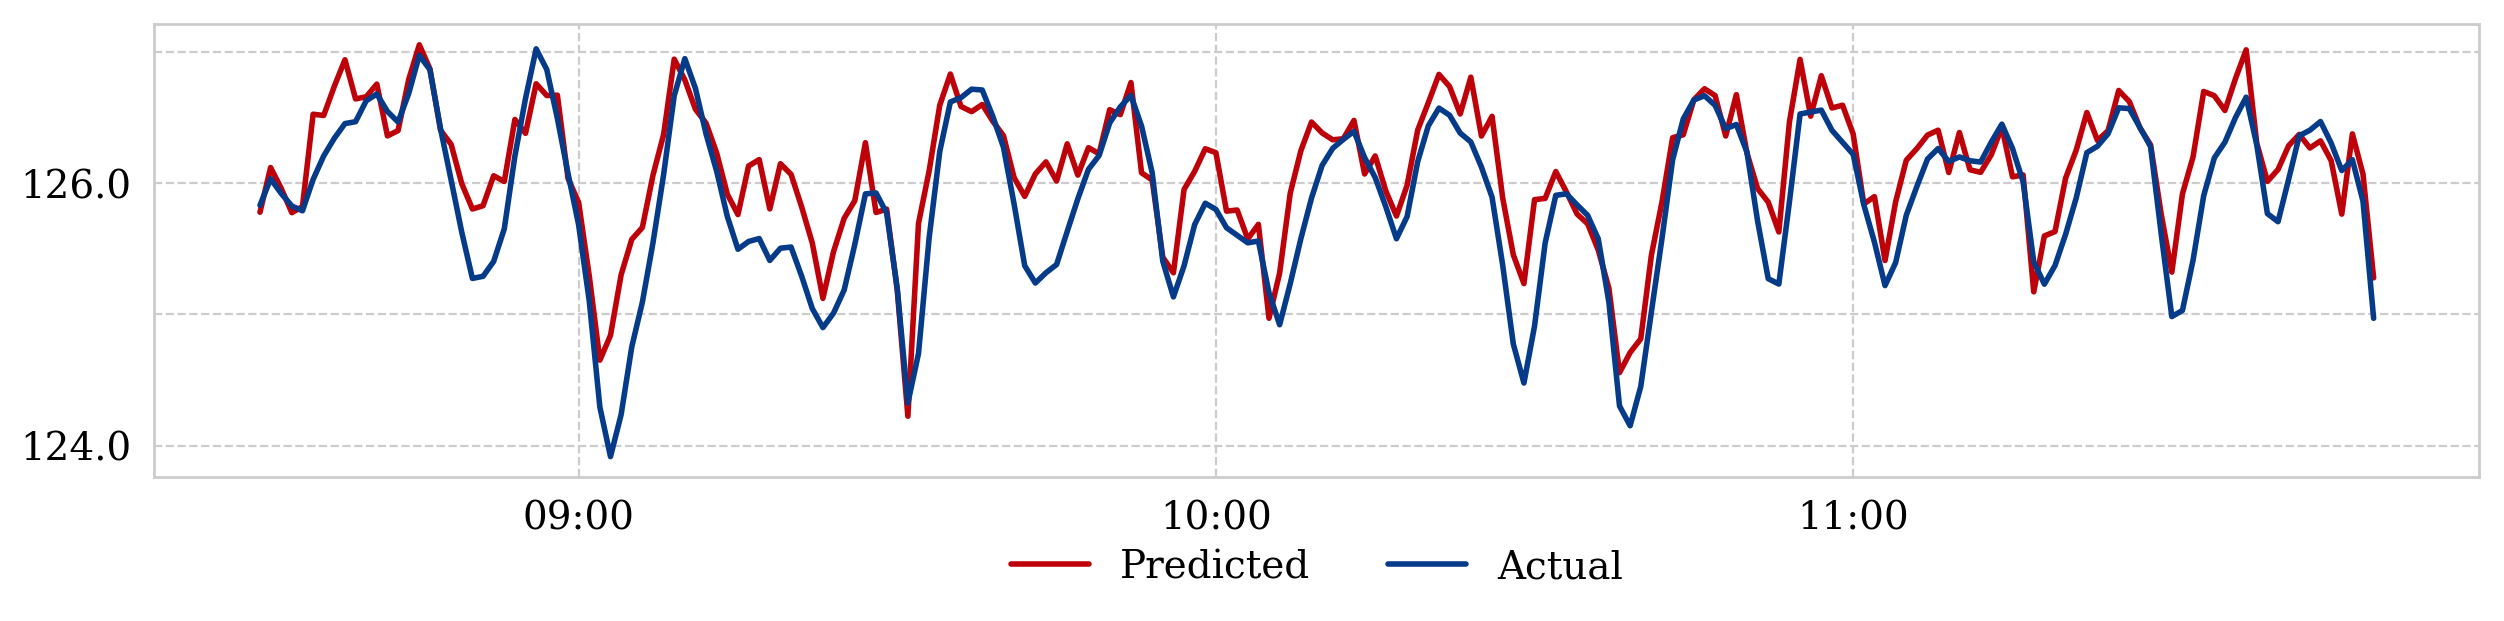

In [46]:
from sklearn.linear_model import Lasso

# using the standard settings https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# find the optimal value for alpha
alphas = np.arange(0.01,1,0.01)
best_alpha = None
best_err = None
for a in alphas: 
    model = Lasso(alpha = a)
    model.fit(x_train,y_train)
    
    preds = model.predict(x_valid)
    targets = y_valid
    val_err = evaluate_error(preds,targets)['avg_mae']
    if best_err is None or val_err < best_err:
        best_alpha = a
        best_err = val_err

print("Best alpha by validation is:", best_alpha)
    
lasso = Lasso(alpha=best_alpha)
lasso.fit(x_train, y_train)

print("\n **** LASSO REGRESSION MODEL ****")
val_lasso, test_lasso = evaluate_linear_model(lasso, x_valid, y_valid, x_test, y_test)
plot_linear_model(lasso)

### Elastic Nets (ElNet)
Hybrid between Ridge and LASSO. Linear regression with combined L1 and L2 priors as regularizers. Parameters to optimise with these models are alpha and l1_ratio. These are found using an exhaustive grid search and hold-out validation.

Best parameters are alpha=0.01, l1_ratio=0.01 giving a validation error of 0.5016456833953221

 **** ELASTIC NET MODEL ****

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.69858 |             2358.87016 |
|  1 | TT    |              0.29599 |                0.28908 |
|  2 | PT    |              0.51037 |                0.12630 |
|  3 | Avg   |              0.50165 |              786.42852 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.61412 |             2073.67982 |
|  1 | TT    |              0.26080 |                0.25471 |
|  2 | PT    |            

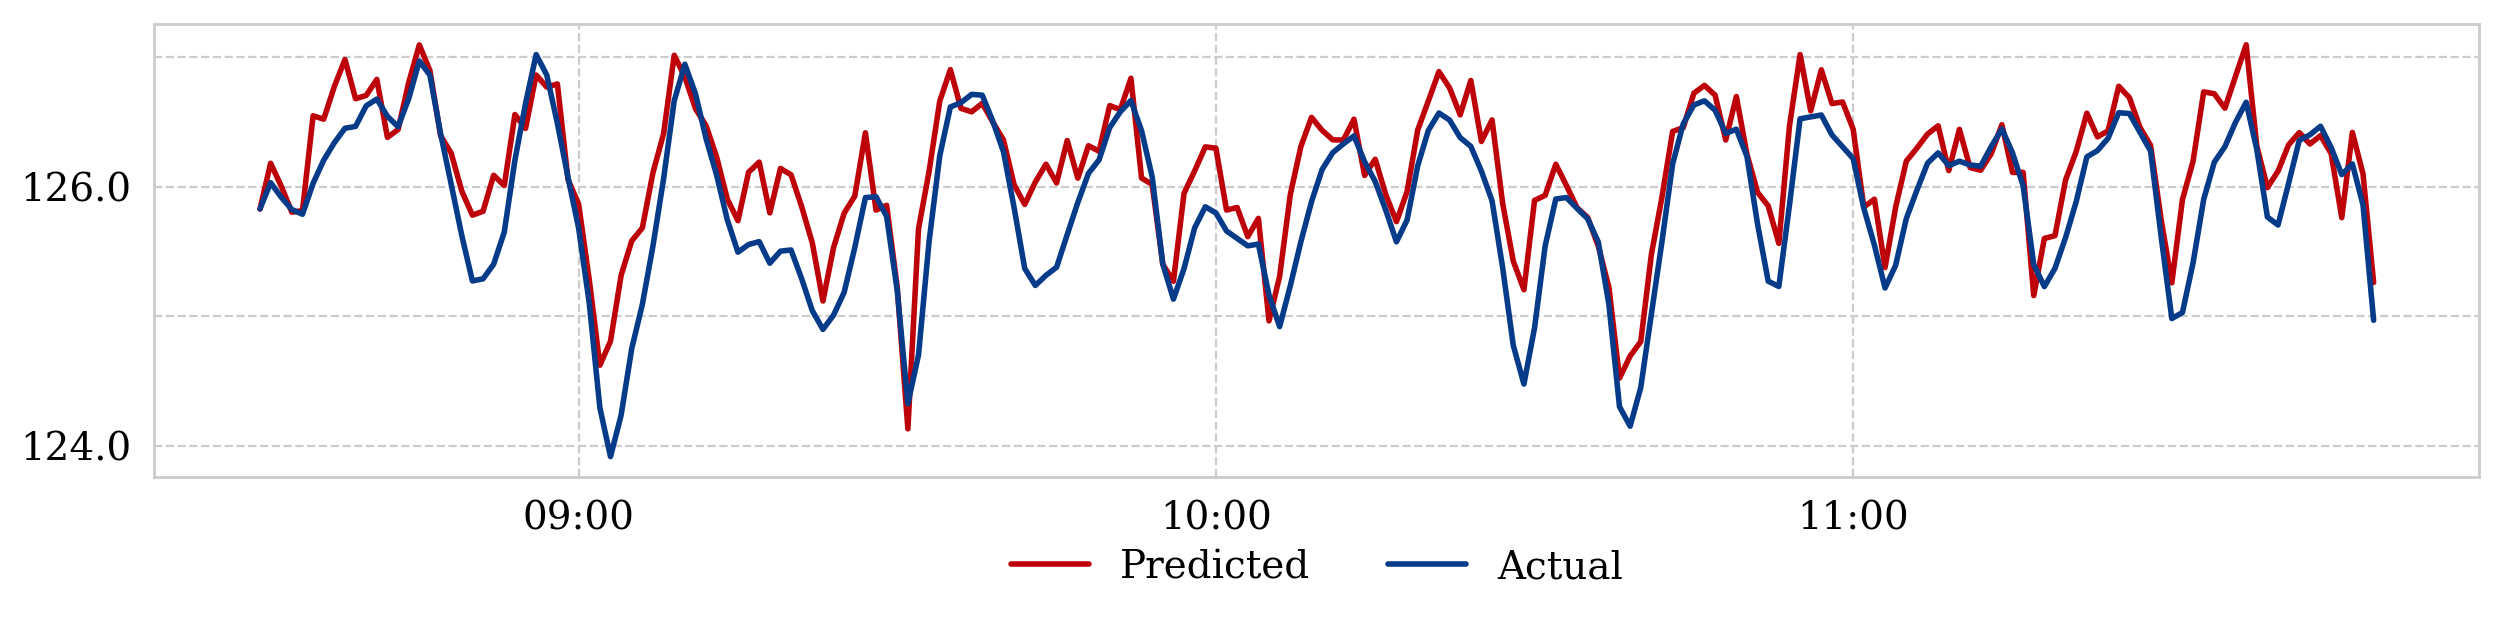

In [47]:
from sklearn.linear_model import ElasticNet

# find optimal value of alpha

alphas = np.arange(0.01,1,0.01)
l1s = [.01, .1, .4, .5, .7, .9, .95, .97, .99, 1]
best_params = (alphas[0],l1s[0])
best_err = np.inf
for a in alphas: 
    for l1 in l1s: 
        model = ElasticNet(alpha = a, l1_ratio=l1, max_iter=2000)
        model.fit(x_train,y_train)

        preds = model.predict(x_valid)
        targets = y_valid
        val_err = evaluate_error(preds,targets)['avg_mae']
        if val_err < best_err:
            best_params = (a,l1)
            best_err = val_err
print("Best parameters are alpha={0}, l1_ratio={1} giving a validation error of {2}".format(
        best_params[0], best_params[1], best_err))
        
elnet = ElasticNet(alpha=best_params[0], l1_ratio=best_params[1], max_iter=2000)
elnet.fit(x_train, y_train)

print("\n **** ELASTIC NET MODEL ****")
val_elnet, test_elnet = evaluate_linear_model(elnet, x_valid, y_valid, x_test, y_test)
plot_linear_model(elnet)

### Summary for Linear Models

In [48]:
indexes = ['Linear', 'Ridge', 'LASSO', 'ElNet']
columns = ['FT', 'TT', 'PT', 'Avg']
texpath = ROOT_PATH + "latex-exports/benchmarks/" + "linear_models_error_table.tex"
linear_df, tex = get_summary(val_dicts = [val_linear, val_ridge, val_lasso, val_elnet], 
                                   test_dicts = [test_linear, test_ridge, test_lasso, test_elnet],
                                   columns=columns, indexes=indexes, unstd=False)

# sorted 
linear_df = linear_df.sort_values(by=('Test','Avg'))
#print(latexify(linear_df))
linear_df

Validation                            Test                        
               FT      TT      PT     Avg      FT      TT      PT     Avg
Linear     0.6987  0.2902  0.5101  0.4997  0.6158  0.2527  0.4907   0.453
Ridge      0.6987  0.2902  0.5101  0.4997  0.6158  0.2527  0.4907   0.453
ElNet      0.6986   0.296  0.5104  0.5016  0.6141  0.2608  0.4905  0.4551
LASSO      0.6974   0.301  0.5116  0.5034  0.6112   0.271  0.4912  0.4578

---

# [3] Simple Machine Learning Models

To account for possible non-linear relationships in the data, we implement two tree-based methods called Random Forest (RF) and Gradient Boosting Machines (GBM). Tree-based methods may potentially learn statistical structures that the linear models cannot and are therefore considered stronger baselines.

---

#### Functions to evaluate and plot the models

In [49]:
def evaluate_ml(model, params, ntrees_per_signal, 
                use_multivariate=False,
                x_train=x_train, y_train=y_train, 
                x_valid=x_valid, y_valid=y_valid, 
                x_test=x_test, y_test=y_test):
    
    val_predictions = np.zeros(y_valid.shape)
    test_predictions = np.zeros(y_test.shape)
    
    if use_multivariate:
        model.fit(x_train, y_train)
        val_predictions = model.predict(x_valid)
        test_predictions = model.predict(x_test)

    else: 
        for signal in range(y_train.shape[-1]):
            ntrees = ntrees_per_signal[signal]
            params['n_estimators'] = ntrees
            model.set_params(**params)
            model.fit(x_train, y_train[:,signal])

            val_predictions[:,signal] = model.predict(x_valid)
            test_predictions[:,signal] = model.predict(x_test)
            
            print("✓ {0}/{1} ".format(signal+1, len(target_tags)))
    
    val_errs = evaluate_error(val_predictions, y_valid)
    test_errs = evaluate_error(test_predictions, y_test)
    
    print("\nValidation data")
    print(val_errs['err_table'])
    
    print("\nTesting data")
    print(test_errs['err_table'])
    
    return [val_errs, test_errs]

### Random Forest
Ensemble method that averages a lot of trees grown on different samples of the training data, they reduce the variance. Bagging, or Bootstrap Aggregation, will bootstrap $B$ samples from the dataset, fit a tree for every sample and average the outcome. By averaging the outcomes of many trees, Bagging will reduce the sampling variablity. However, if the bagged trees are highly correlated and produce similar outcomes, the improvement won't be substantial. This will be the case if the dataset has one or more dominant predictors that most trees consistently will use as a split-predictor. Random Forest decorrelates the trees by randomly sampling $m$ predictors to be considered every time a tree is to be grown. As with Bagging, Random Forests are built by bootstrapping $B$ samples from the dataset. For every sample, it will fit a tree, but only $m$ predictors is used as split candidates for the trees. Notice that Bagging is the same as Random Forests for $m$ = $p$, where $p$ is the total number of predictors in the data.

Note that we implement one model for each target, as we found this to be beneficial performance wise. 

In [50]:
from sklearn.ensemble import RandomForestRegressor
params_rf = {'n_estimators': 1500, 'max_depth': None, 'min_samples_split': 2, 'max_features':'auto', 
             'criterion':'mse', 'random_state':0, 'n_jobs':-1, 'oob_score':True}

rf = RandomForestRegressor(**params_rf)

In [51]:
# find the optimal number of trees
def get_oob_per_tree(rf_model, x_train, y_train, ntrees_min=50, ntrees_max=2000, delta=50):
    
    trees_arr = np.arange(ntrees_min,ntrees_max+delta,delta)
    trees_arr = np.append([10], trees_arr)
    if trees_arr[-1] < ntrees_max:
        np.append(trees_arr, ntrees_max)
    
    oob_errors = np.zeros(len(trees_arr))
    best_trees = trees_arr[0]
    best_err = np.inf
    
    for i, ntrees in enumerate(trees_arr):
        params_rf['n_estimators'] = ntrees
        rf_model.set_params(**params_rf)
        rf_model.fit(x_train, y_train)
        
        err = 1 - rf_model.oob_score_
        oob_errors[i] = err
        
        if err < best_err:
            best_err = err
            best_trees = ntrees
        
        
        print("✓({0}%) ntrees: {1}, oob_error: {2}".format(
            round(100*ntrees/ntrees_max,2), ntrees, round(err,4)))

            
    fig, ax = plt.subplots()
    ax.plot(trees_arr, oob_errors, marker='o', markersize=3, color="darkblue")
    ax.set_xlabel("Number of trees")
    ax.set_ylabel("OOB error")
    ax.set_title("Random Forest OOB error development")
        
    return oob_errors, best_trees, fig

ntrees_min = 100
ntrees_max = 3000
delta = 100

PLOT_OOB = False
if PLOT_OOB: 
    oob_errors, best_trees, fig = get_oob_per_tree(rf, x_train, y_train, ntrees_min, ntrees_max, delta)

In [52]:
ntrees = best_trees if PLOT_OOB else 3000
    
print("\n **** RANDOM FOREST ****")
val_rf, test_rf = evaluate_ml(rf, params_rf, ntrees_per_signal=[ntrees,ntrees,ntrees])


 **** RANDOM FOREST ****
✓ 1/3 
✓ 2/3 
✓ 3/3 

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.66759 |             2254.23129 |
|  1 | TT    |              0.33834 |                0.33044 |
|  2 | PT    |              0.52239 |                0.12928 |
|  3 | Avg   |              0.50944 |              751.56367 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.60457 |             2041.42162 |
|  1 | TT    |              0.29181 |                0.28499 |
|  2 | PT    |              0.51269 |                0.12688 |
|  3 | Avg   |              0.46969 |   

### Gradient Boosting Machines

Boosting is another ensemble method that aims to improve stability and predictive accuracy of a single tree by combining many of them. In Random Forests and Bagging the trees are grown independently of each other. This is not the case for Boosting, however, where the trees are grown using information from previously grown trees. More specifically, the residuals from the previously grown tree is used as the response variable when growing the next. The trees will only have a small number of splits each, denoted $d$. This yields a sequence of $B$ trees, where each tree accounts for some variation in $y$ that was not captured by the previous trees. The boosting method is a slow learner, and will in general require many trees to get good results. In the end, boosting will often beat methods like Random Forest, although it is comparably much more computationally expensive.

Gradient Boosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

Here, we set the number of trees to 10000 and the learning rate to 0.002. Then the validation MAE is calculated for each of the target variables. For each target, the number of trees that give the least validation error is chosen. This is then used to

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
params_gbm = {'n_estimators': 10000, 'max_depth': 5, 'min_samples_split': 2,
              'learning_rate': 0.002, 'loss': 'lad'}

gbm = GradientBoostingRegressor(**params_gbm)

In [54]:
best_trees = [10000,10000,10000]
CALCULATE_NTREES = False
if CALCULATE_NTREES:
    train_scores = np.zeros(shape=(params_gbm['n_estimators'],y_train.shape[-1]))
    valid_scores = np.zeros(shape=(params_gbm['n_estimators'],y_train.shape[-1]))

    for output in range(len(target_tags)):
        gbm.fit(x_train, y_train[:,output])
        print("✓ {0}/{1} ".format(output+1, len(target_tags)))
        train_scores[:,output] = gbm.train_score_

        for i, y_pred in enumerate(gbm.staged_predict(x_valid)):
            valid_scores[i,output] = gbm.loss_(y_valid[:,output], y_pred)

    for out in range(train_scores.shape[-1]):
        plt.figure()
        plt.plot(train_scores[:,out], c="darkred", label="Training scores")
        plt.plot(valid_scores[:,out], c="darkblue", label="Validation scores")
        plt.legend(frameon=True)
        plt.ylabel(target_tags[out])
        plt.show()
        
    best_trees = [np.where(valid_scores[:,sig] == min(valid_scores[:,sig])) for sig in range(len(target_tags))]
    best_trees = [t[0][0] for t in best_trees]
    print(best_trees)

print("\n **** Gradient Boosting ****")
val_gbm, test_gbm = evaluate_ml(gbm, params_gbm, best_trees)


 **** Gradient Boosting ****
✓ 1/3 
✓ 2/3 
✓ 3/3 

Validation data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.65575 |             2214.25648 |
|  1 | TT    |              0.32144 |                0.31393 |
|  2 | PT    |              0.50976 |                0.12616 |
|  3 | Avg   |              0.49565 |              738.23219 |
+----+-------+----------------------+------------------------+

Testing data
+----+-------+----------------------+------------------------+
|    | Tag   |   MAE (Standardized) |   MAE (Unstandardized) |
|----+-------+----------------------+------------------------|
|  0 | FT    |              0.58980 |             1991.55326 |
|  1 | TT    |              0.26807 |                0.26181 |
|  2 | PT    |              0.50770 |                0.12564 |
|  3 | Avg   |              0.45519 

### Summary for Simple Machine Learning

In [55]:
indexes = ['RF', 'GBM']
columns = ['FT', 'TT', 'PT', 'Avg']

ml_df, tex = get_summary(val_dicts = [val_rf, val_gbm], 
                               test_dicts = [test_rf, test_gbm],
                               columns=columns, indexes=indexes, unstd=False)
print(tex)
ml_df

\begin{tabular}{lcccccccc}
\toprule
{} & \multicolumn{4}{c}{Validation} & \multicolumn{4}{c}{Test} \\
{} &         FT &      TT &      PT &     Avg &      FT &      TT &      PT &     Avg \\
\midrule
\textbf{RF } &     0.6676 &  0.3383 &  0.5224 &  0.5094 &  0.6046 &  0.2918 &  0.5127 &  0.4697 \\
\textbf{GBM} &     0.6558 &  0.3214 &  0.5098 &  0.4956 &  0.5898 &  0.2681 &  0.5077 &  0.4552 \\
\bottomrule
\end{tabular}



Validation                            Test                        
            FT      TT      PT     Avg      FT      TT      PT     Avg
RF      0.6676  0.3383  0.5224  0.5094  0.6046  0.2918  0.5127  0.4697
GBM     0.6558  0.3214  0.5098  0.4956  0.5898  0.2681  0.5077  0.4552

## [4] Benchmarks summary
---

In [56]:
dfs = [simple_heuristics_df, linear_df, ml_df]
benchmark_summary_df = pd.concat(dfs,axis=0)
#tex = benchmark_summary_df.to_latex(column_format="l" + "c"*(benchmark_summary_df.shape[-1]), bold_rows=True)
benchmark_summary_df

Validation                            Test                        
               FT      TT      PT     Avg      FT      TT      PT     Avg
Prev.      0.9073  0.2212  0.5586  0.5624   0.784   0.183  0.5157  0.4942
Mean       0.8573  1.3853  0.8329  1.0252  0.8107  1.6927  0.7612  1.0882
MA         0.8342  0.7101  0.8331  0.7925  0.7439  0.7148  0.7606  0.7398
Linear     0.6987  0.2902  0.5101  0.4997  0.6158  0.2527  0.4907   0.453
Ridge      0.6987  0.2902  0.5101  0.4997  0.6158  0.2527  0.4907   0.453
ElNet      0.6986   0.296  0.5104  0.5016  0.6141  0.2608  0.4905  0.4551
LASSO      0.6974   0.301  0.5116  0.5034  0.6112   0.271  0.4912  0.4578
RF         0.6676  0.3383  0.5224  0.5094  0.6046  0.2918  0.5127  0.4697
GBM        0.6558  0.3214  0.5098  0.4956  0.5898  0.2681  0.5077  0.4552

In [57]:
avg_summary_df = pd.concat([benchmark_summary_df[('Validation', 'Avg')], 
                            benchmark_summary_df[('Test', 'Avg')]], 
                            axis=1).sort_values(by=[('Test', 'Avg')])
#tex = avg_summary_df.to_latex(column_format="l" + "c"*(len(columns)), bold_rows=True)
avg_summary_df

,Validation,Test
,Avg,Avg
Linear,0.4997,0.453
Ridge,0.4997,0.453
ElNet,0.5016,0.4551
GBM,0.4956,0.4552
LASSO,0.5034,0.4578
RF,0.5094,0.4697
Prev.,0.5624,0.4942
MA,0.7925,0.7398
Mean,1.0252,1.0882


#### Export results 

In [57]:
# save dfs
savepath = ROOT_PATH + "models/dataframes/"

simple_heuristics_df.to_pickle(savepath + "simple_heuristics_df.pkl")
linear_df.to_pickle(savepath + "linear_models_df.pkl")
ml_df.to_pickle(savepath + "ml_df.pkl")
benchmark_summary_df.to_pickle(savepath + "benchmarks_summary_df.pkl")
avg_summary_df.to_pickle(savepath + "avg_benchmarks_summary_df.pkl")